<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT21/blob/theogri_lab4/Lab4/theogri_lab4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Fluid-structure interaction - Question 2**
**Theo Grimonprez**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Elasticity equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Elasticity equations take the form

$-\nabla \cdot \sigma = f$

together with suitable boundary conditions.

To derive the weak form of the equations, multiply the equation by $v\in V$, and then integrate over the domain $\Omega$ and use Green's formula
$
(-\nabla \cdot \sigma ,v) = (\nabla \sigma , \nabla v) 
- <\sigma \cdot n, v>_{\Gamma}
$

To model 

We seek a finite element approximation $u\in V$ such that 

$(\nabla \sigma,\nabla v) - <\sigma \cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $v \in V$. 



# **Method**

**Define domain and mesh**

In [ ]:
# Define rectangular domain 
L = 4.0
H = 2.0

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [ ]:
# Generate finite element space
VE = VectorElement("CG", mesh.ufl_cell(), 1)

V = FunctionSpace(mesh, VE)

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V) 

d = Function(V)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


**Define boundary conditions**

In [ ]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.5, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]

# **Results**

**Define and solve variational problem**

In [ ]:
f = Expression(("0.0","0.0"), element = V.ufl_element())

dim = u.geometric_dimension()
E = 1.0e10 ## CHANGING E DOES NOT CHANGE THE RESPONSE 
nu = 0.3 ## INCREASING NU LEADS TO AN INCREASE IN LATERAL CONSTRAINT (CRUSHED WAVE BEHIND)
mu = E*0.5/(1+nu)
lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)

def sigma(u):
    #return 2.0*mu*epsilon(u)
    return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)

# Define variational problem on residual form: r(u,v) = 0
residual = ( inner(sigma(u), epsilon(v))*dx - inner(f, v)*dx )

au = lhs(residual)
Lu = rhs(residual)

A = assemble(au)
b = assemble(Lu)

[bc.apply(A, b) for bc in bcu]
[bc.apply(d.vector()) for bc in bcu]

solve(A, d.vector(), b, "bicgstab", "default")

**2. Observe how the elastic material (the mesh) is deformed as a response to how the cylinders are moved inside the domain. Modify Young's modulus and Poisson's ratio, how does the response change? Change the movement of the cylinders, how does that change the deformation of the material?**

As cylinders are moved inside the domain, the mesh is deformed elastically, stretched in the motion's direction before the leading cylinder, and compressed in the same direction after the same cylinder. However, since the mesh is compressed in a small area after the cylinder it can e expected that the next cylinder's motion, if it is close enough, will not give the same behavior. 

**Note:** For example, imagining a chain of cylinders close enough one to the other and moving in the same direction. The mesh between each pair being both extended and compressed at the same time (in front of a cylinder and behind an other), it could remain unchanged. 

The influence of each cylinder on the mesh near others can be observed in the mesh deformation, as both the second and third cyclinder show a slight diagonal deformation instead of a horizontal one.

It can also be expected that for certain motions (for example a high speed motion), the elasticity of the materiel is going to reach its limit and irreversible deformations can appear. For extreme motions rupture can be expected, and discontinuity within the mesh. 

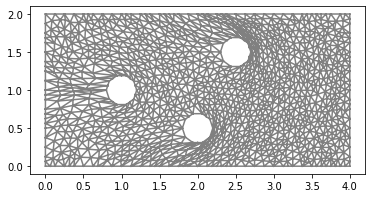

*Deformation for the initial motion, a displacement of 0.5 in the horizontal direction*

The deformation of the mesh for a certain displacement can be modified by changing the Young's Modulus $E$ and the Poisson's Ratio $\nu$. 

The difference that any modification of $E$ or $\nu$ can be easily predicted by using knowledge from solid mechanics. 

$E=\frac{\sigma}{\epsilon}$ translates how a certain axial constraint is going to influence the deformation. For this reason, and because there are no constraints involved here, changing $E$ will only change the required axial constraint to reach the final state, but the final state will remain the same. 

$\nu=-\frac{\epsilon_{trans}}{\epsilon_{axial}}$ translates how much an object will be compressed vertically if given a certain horizontal extension (works also with extension/compression respectively). Increasing $\nu$ is expected to increase the vertical compression of the mesh behind the cylinder, leaving the horizontal extension unchanged.

By changing $E$ in the code, the final state does not change, no matter the value. That confirms the behavior that was expected.
As for $\nu$, increasing it does lead to a compression in the vertical direction, until the critical value $\nu=0.5$ that can be approached but never reached.

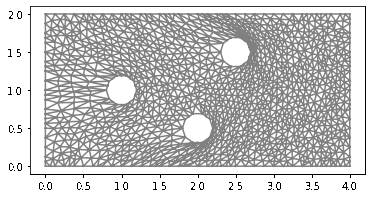

*Evolution of the mesh for $\nu$ between 0.1 and 0.49.*

Changing the movement of the cylinders does not change the behavior. Since the displacement is a straight line, the mesh is always streched behind the first object in the motion's direction, and compressed in front. As for the other cylinders, the mesh deformation around them is still modified by the leading cylinder.

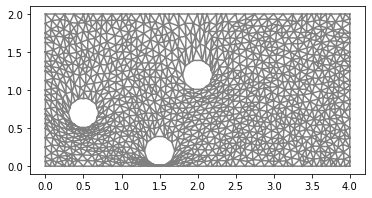
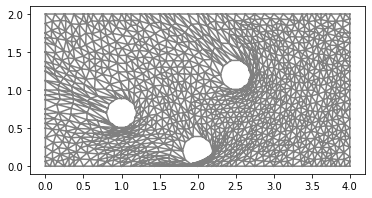

*Deformation of the mesh for a vertical displacement of $-0.3$ (left) and a diagonal displacement ($0.5$ along $x$ and $-0.3$ along $y$) (right)*

**Note:** Some surprising behavior can be observed near the edge of the domain, as many cells are compressed in a tiny space. It is unclear what consequences this can have for a simulation.

**Visualize solution and export files**

In [ ]:
u1 = project(d, V)

# Plot solution
plt.figure()
plot(u1, title="Displacement")

plt.show()

**Update mesh**

In [ ]:
ALE.move(mesh, d)
plt.figure()
plot(mesh)
plt.show()

# **Discussion**

A Elasticity equation was solved with a finite element method.